# Adult Income Classification Experiment

Name : Tanuj Kapoor  
ID : 2025AA05734

## Objective
Compare various classification ML models on the Adult Income dataset from UCI ML Repository to predict whether income exceeds $50K/year based on census data.

## Models to be evaluated:
1. Logistic Regression
2. Decision Tree Classifier
3. K-Nearest Neighbor Classifier
4. Naive Bayes Classifier (Gaussian)
5. Ensemble Model - Random Forest
6. Ensemble Model - XGBoost

## Evaluation Metrics:
- Accuracy
- AUC Score
- Precision
- Recall
- F1 Score
- Matthews Correlation Coefficient (MCC Score)

In [1]:
# Install exact versions matching Streamlit Cloud deployment
!pip install ucimlrepo pandas==2.3.3 numpy==1.26.4 scikit-learn==1.5.2 scipy==1.17.0 xgboost==3.2.0 matplotlib==3.10.8 seaborn==0.13.2 joblib==1.5.3

## 1. Import Libraries

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import time
import warnings
import pickle
import os

from ucimlrepo import fetch_ucirepo

# Classification models and metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, roc_auc_score, precision_score,
                             recall_score, f1_score, matthews_corrcoef,
                             confusion_matrix, ConfusionMatrixDisplay)

# Set random seed
warnings.filterwarnings('ignore')
np.random.seed(42)
print('Libraries imported successfully')

Libraries imported successfully


## 2. Load Dataset

In [3]:
# Fetch Adult Income dataset from UCI ML Repository
adult = fetch_ucirepo(id=2)

# Extract features and target
X = adult.data.features
y = adult.data.targets

# Display metadata
print("="*70)
print("DATASET METADATA")
print("="*70)
print(adult.metadata)
print("\n" + "="*70)
print("VARIABLE INFORMATION")
print("="*70)
print(adult.variables)

# Dataset information
dataset_name = "Adult Income (Census Income)"
dataset_source = "UCI ML Repository"
n_samples = len(X)
n_features = X.shape[1]
problem_type = "Binary Classification"

print("\n" + "="*70)
print("DATASET SUMMARY")
print("="*70)
print(f"Dataset: {dataset_name}")
print(f"Source: {dataset_source}")
print(f"Samples: {n_samples}")
print(f"Features: {n_features}")
print(f"Problem Type: {problem_type}")
print(f"Target Variable: {y.columns[0]} (>50K or <=50K)")
print(f"\nFeature names: {list(X.columns)}")
print("="*70)

DATASET METADATA
{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extrac

## 3. Data Preprocessing

In [4]:
# Handle missing values - drop rows with any missing values
X_clean = X.dropna()
y_clean = y.loc[X_clean.index]

# Strip whitespace and periods from target variable, removes period observed in some data-points
y_clean = y_clean.apply(lambda x: x.str.strip().str.rstrip('.'))

# Identify numerical and categorical columns
numerical_features = X_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_clean.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumerical features ({len(numerical_features)}): {numerical_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

# Encode target variable (<=50K=0, >50K=1)
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(y_clean.values.ravel())

print(f"\n{'='*70}")
print("DATA PREPROCESSING SUMMARY")
print("="*70)
print(f"Shape of X: {X_clean.shape}")
print(f"Shape of y: {Y_encoded.shape}")
print(f"Target classes: {label_encoder.classes_}")
print(f"Class encoding: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")
print(f"Class distribution: {dict(zip(label_encoder.classes_, np.bincount(Y_encoded)))}")
print("="*70)


Numerical features (6): ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical features (8): ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

DATA PREPROCESSING SUMMARY
Shape of X: (47621, 14)
Shape of y: (47621,)
Target classes: ['<=50K' '>50K']
Class encoding: {'<=50K': 0, '>50K': 1}
Class distribution: {'<=50K': 36080, '>50K': 11541}


## 4. Exploratory Data Analysis (EDA)

NUMERICAL FEATURES STATISTICS
                age        fnlwgt  education-num  capital-gain  capital-loss  \
count  47621.000000  4.762100e+04   47621.000000  47621.000000  47621.000000   
mean      38.640684  1.897271e+05      10.090821   1091.137649     87.853489   
std       13.558961  1.055695e+05       2.568320   7487.228336    404.010612   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.175840e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.782820e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.377200e+05      12.000000      0.000000      0.000000   
max       90.000000  1.490400e+06      16.000000  99999.000000   4356.000000   

       hours-per-week  
count    47621.000000  
mean        40.600050  
std         12.260345  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000  

CATEGORICAL FEATURES - VALUE COU

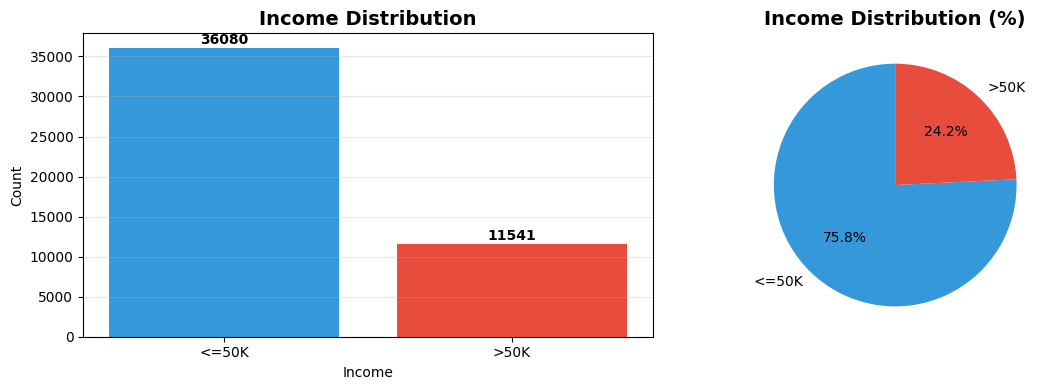


Class Balance:
<=50K (0): 36080 (75.8%)
>50K (1): 11541 (24.2%)


In [5]:
# Basic statistics for numerical features
print("="*70)
print("NUMERICAL FEATURES STATISTICS")
print("="*70)
print(X_clean[numerical_features].describe())

print("\n" + "="*70)
print("CATEGORICAL FEATURES - VALUE COUNTS")
print("="*70)
for col in categorical_features[:3]:  # Show first 3 categorical features
    print(f"\n{col}:")
    print(X_clean[col].value_counts())

# Class distribution visualization
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
class_counts = pd.Series(Y_encoded).value_counts().sort_index()
class_labels = [label_encoder.classes_[i] for i in range(len(label_encoder.classes_))]
plt.bar(class_labels, class_counts.values, color=['#3498db', '#e74c3c'])
plt.title('Income Distribution', fontsize=14, fontweight='bold')
plt.ylabel('Count')
plt.xlabel('Income')
plt.grid(axis='y', alpha=0.3)

for i, v in enumerate(class_counts.values):
    plt.text(i, v + 500, str(v), ha='center', fontweight='bold')

plt.subplot(1, 2, 2)
plt.pie(class_counts.values, labels=class_labels, autopct='%1.1f%%',
        colors=['#3498db', '#e74c3c'], startangle=90)
plt.title('Income Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nClass Balance:")
for i, label in enumerate(class_labels):
    print(f"{label} ({i}): {class_counts.values[i]} ({class_counts.values[i]/len(Y_encoded)*100:.1f}%)")

## 5. Feature Engineering and Train-Test Split

In [6]:
# Create preprocessing pipeline, StandardScaler for numerical features, OneHotEncoder for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])

# Fit and transform the data
X_processed = preprocessor.fit_transform(X_clean)

# Get feature names after encoding
num_feature_names = numerical_features
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([num_feature_names, cat_feature_names])

print("="*70)
print("FEATURE ENGINEERING")
print("="*70)
print(f"Original features: {X_clean.shape[1]}")
print(f"After one-hot encoding: {X_processed.shape[1]}")
print(f"Numerical features: {len(numerical_features)}")
print(f"Categorical features (original): {len(categorical_features)}")
print(f"Categorical features (encoded): {len(cat_feature_names)}")

# Train-test split (80-20) stratefied
# Split both processed and original data, required to provide test data as download in Streamlit app
X_train, X_test, y_train, y_test, X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X_processed, Y_encoded, X_clean, y_clean, test_size=0.2, random_state=42, stratify=Y_encoded
)

print("\n" + "="*70)
print("TRAIN-TEST SPLIT")
print("="*70)
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"\nTrain class distribution: {np.bincount(y_train)}")
print(f"Test class distribution: {np.bincount(y_test)}")

# Save test data sample for Streamlit download (100 samples)
test_sample_size = min(100, len(X_test_orig))
test_sample_indices = np.random.choice(len(X_test_orig), test_sample_size, replace=False)
X_test_sample = X_test_orig.iloc[test_sample_indices].copy()
y_test_sample = y_test_orig.iloc[test_sample_indices].copy()

# Decode target labels back to original format
y_test_sample_decoded = label_encoder.inverse_transform(y_test[test_sample_indices])

# Combine features and target
test_data_export = X_test_sample.copy()
test_data_export['income'] = y_test_sample_decoded

# Create models directory
os.makedirs('model', exist_ok=True)

# Save to CSV
test_data_export.to_csv('model/test_data_sample.csv', index=False)
print(f"\nSaved {test_sample_size} test samples to 'test_data_sample.csv'")
print(f"  Columns: {list(test_data_export.columns)}")

FEATURE ENGINEERING
Original features: 14
After one-hot encoding: 100
Numerical features: 6
Categorical features (original): 8
Categorical features (encoded): 94

TRAIN-TEST SPLIT
Training samples: 38096
Test samples: 9525

Train class distribution: [28863  9233]
Test class distribution: [7217 2308]

Saved 100 test samples to 'test_data_sample.csv'
  Columns: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']


## 6. Model Training and Evaluation

In [7]:
# Helper Function to Evaluate Models
def evaluate_model(model, y_test, y_pred, y_pred_proba, model_name, training_time):
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Print results
    print(f"\n{'='*70}")
    print(f"Evaluation: {model_name}")
    print('='*70)
    print(f"Training Time: {training_time:.4f} seconds")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"AUC Score: {auc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"MCC Score: {mcc:.4f}")
    print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'AUC Score': auc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'MCC Score': mcc,
        'Training Time': training_time,
        'Confusion Matrix': cm,
        'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp
    }

# Storage for results and predictions
results = []
trained_models = {}
model_predictions = {}

### 6.0 Hyperparameter Tuning Configuration

In [8]:
# Define hyperparameter grids for each model

# Logistic Regression parameters
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [1000]
}

# Decision Tree parameters
dt_param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# K-Nearest Neighbors parameters
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Naive Bayes parameters
nb_param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# Random Forest parameters
rf_param_grid = {
    'n_estimators': [30, 50],  # Reduced from [50, 100, 200]
    'max_depth': [10, 15],  # Reduced from [10, 20, 30, None]
    'min_samples_split': [5, 10],  # Increased minimum
    'min_samples_leaf': [4, 8],  # Increased from [1, 2, 4]
    'max_features': ['sqrt']  # Only sqrt (log2 removed)
}

# XGBoost parameters
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

### 6.1 Logistic Regression

In [9]:
# Train and evaluate Logistic Regression with hyperparameter tuning
print(f"\n{'='*70}")
print("Training Logistic Regression")
print('='*70)

lr_base = LogisticRegression(random_state=42)
lr_grid = GridSearchCV(lr_base, lr_param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
start_time = time.time()
lr_grid.fit(X_train, y_train)
training_time = time.time() - start_time
lr_model = lr_grid.best_estimator_

print(f"Best parameters: {lr_grid.best_params_}")
print(f"Best CV AUC score: {lr_grid.best_score_:.4f}")

# Make predictions
y_pred_lr = lr_model.predict(X_test)
y_pred_proba_lr = lr_model.predict_proba(X_test)[:, 1]

# Store model and predictions
trained_models['Logistic Regression'] = lr_model
model_predictions['Logistic Regression'] = {
    'y_pred': y_pred_lr,
    'y_pred_proba': y_pred_proba_lr
}

# Evaluate
lr_results = evaluate_model(lr_model, y_test, y_pred_lr, y_pred_proba_lr,
                            "Logistic Regression", training_time)
results.append(lr_results)


Training Logistic Regression
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'C': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV AUC score: 0.9063

Evaluation: Logistic Regression
Training Time: 37.4138 seconds
Accuracy:  0.8488
AUC Score: 0.9032
Precision: 0.7256
Recall:    0.6049
F1 Score:  0.6597
MCC Score: 0.5674
Confusion Matrix: TN=6689, FP=528, FN=912, TP=1396


### 6.2 Decision Tree Classifier

In [10]:
# Train and evaluate Decision Tree
print(f"\n{'='*70}")
print("Training Decision Tree")
print('='*70)

dt_base = DecisionTreeClassifier(random_state=42)
dt_grid = GridSearchCV(dt_base, dt_param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
start_time = time.time()
dt_grid.fit(X_train, y_train)
training_time = time.time() - start_time
dt_model = dt_grid.best_estimator_

print(f"Best parameters: {dt_grid.best_params_}")
print(f"Best CV AUC score: {dt_grid.best_score_:.4f}")

# Make predictions
y_pred_dt = dt_model.predict(X_test)
y_pred_proba_dt = dt_model.predict_proba(X_test)[:, 1]

# Store model and predictions
trained_models['Decision Tree'] = dt_model
model_predictions['Decision Tree'] = {
    'y_pred': y_pred_dt,
    'y_pred_proba': y_pred_proba_dt
}

# Evaluate
dt_results = evaluate_model(dt_model, y_test, y_pred_dt, y_pred_proba_dt,
                            "Decision Tree", training_time)
results.append(dt_results)


Training Decision Tree
Fitting 3 folds for each of 90 candidates, totalling 270 fits
Best parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best CV AUC score: 0.9000

Evaluation: Decision Tree
Training Time: 83.5318 seconds
Accuracy:  0.8584
AUC Score: 0.9032
Precision: 0.7708
Recall:    0.5914
F1 Score:  0.6693
MCC Score: 0.5894
Confusion Matrix: TN=6811, FP=406, FN=943, TP=1365


### 6.3 K-Nearest Neighbor Classifier

In [11]:
# Train and evaluate K-Nearest Neighbor
print(f"\n{'='*70}")
print("Training K-Nearest Neighbor")
print('='*70)

# Use subset of 70% to reduce model size to <25MB and manage around github's restriction on file size
from sklearn.model_selection import train_test_split as split_subset
X_train_knn, _, y_train_knn, _ = split_subset(
    X_train, y_train, train_size=0.7, random_state=42, stratify=y_train
)
print(f"KNN Training subset: {len(X_train_knn)} samples (70% of training data)")

knn_base = KNeighborsClassifier()
knn_grid = GridSearchCV(knn_base, knn_param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
start_time = time.time()
knn_grid.fit(X_train_knn, y_train_knn)
training_time = time.time() - start_time
knn_model = knn_grid.best_estimator_

print(f"Best parameters: {knn_grid.best_params_}")
print(f"Best CV AUC score: {knn_grid.best_score_:.4f}")

# Make predictions
y_pred_knn = knn_model.predict(X_test)
y_pred_proba_knn = knn_model.predict_proba(X_test)[:, 1]

# Store model and predictions
trained_models['K-Nearest Neighbor'] = knn_model
model_predictions['K-Nearest Neighbor'] = {
    'y_pred': y_pred_knn,
    'y_pred_proba': y_pred_proba_knn
}

# Evaluate
knn_results = evaluate_model(knn_model, y_test, y_pred_knn, y_pred_proba_knn,
                             "K-Nearest Neighbor", training_time)
results.append(knn_results)


Training K-Nearest Neighbor
KNN Training subset: 26667 samples (70% of training data)
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}
Best CV AUC score: 0.8832

Evaluation: K-Nearest Neighbor
Training Time: 493.6171 seconds
Accuracy:  0.8372
AUC Score: 0.8825
Precision: 0.6810
Recall:    0.6170
F1 Score:  0.6474
MCC Score: 0.5430
Confusion Matrix: TN=6550, FP=667, FN=884, TP=1424


### 6.4 Naive Bayes Classifier

In [12]:
# Train and evaluate Naive Bayes (Gaussian)
print(f"\n{'='*70}")
print("Training Naive Bayes (Gaussian)")
print('='*70)

nb_base = GaussianNB()
nb_grid = GridSearchCV(nb_base, nb_param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
start_time = time.time()
nb_grid.fit(X_train, y_train)
training_time = time.time() - start_time
nb_model = nb_grid.best_estimator_

print(f"Best parameters: {nb_grid.best_params_}")
print(f"Best CV AUC score: {nb_grid.best_score_:.4f}")

# Make predictions
y_pred_nb = nb_model.predict(X_test)
y_pred_proba_nb = nb_model.predict_proba(X_test)[:, 1]

# Store model and predictions
trained_models['Naive Bayes (Gaussian)'] = nb_model
model_predictions['Naive Bayes (Gaussian)'] = {
    'y_pred': y_pred_nb,
    'y_pred_proba': y_pred_proba_nb
}

# Evaluate
nb_results = evaluate_model(nb_model, y_test, y_pred_nb, y_pred_proba_nb,
                            "Naive Bayes (Gaussian)", training_time)
results.append(nb_results)


Training Naive Bayes (Gaussian)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best parameters: {'var_smoothing': 1e-05}
Best CV AUC score: 0.8527

Evaluation: Naive Bayes (Gaussian)
Training Time: 1.2481 seconds
Accuracy:  0.6435
AUC Score: 0.8492
Precision: 0.3972
Recall:    0.9107
F1 Score:  0.5532
MCC Score: 0.4042
Confusion Matrix: TN=4027, FP=3190, FN=206, TP=2102


### 6.5 Ensemble Model - Random Forest

In [13]:
# Train and evaluate Random Forest
print(f"\n{'='*70}")
print("Training Random Forest")
print('='*70)

rf_base = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf_base, rf_param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
start_time = time.time()
rf_grid.fit(X_train, y_train)
training_time = time.time() - start_time
rf_model = rf_grid.best_estimator_

print(f"Best parameters: {rf_grid.best_params_}")
print(f"Best CV AUC score: {rf_grid.best_score_:.4f}")

# Make predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Store model and predictions
trained_models['Random Forest'] = rf_model
model_predictions['Random Forest'] = {
    'y_pred': y_pred_rf,
    'y_pred_proba': y_pred_proba_rf
}

# Evaluate
rf_results = evaluate_model(rf_model, y_test, y_pred_rf, y_pred_proba_rf,
                            "Random Forest", training_time)
results.append(rf_results)


Training Random Forest
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Best CV AUC score: 0.9138

Evaluation: Random Forest
Training Time: 50.6816 seconds
Accuracy:  0.8620
AUC Score: 0.9141
Precision: 0.7965
Recall:    0.5784
F1 Score:  0.6702
MCC Score: 0.5977
Confusion Matrix: TN=6876, FP=341, FN=973, TP=1335


### 6.6 Ensemble Model - XGBoost

In [14]:
# Train and evaluate XGBoost
print(f"\n{'='*70}")
print("Training XGBoost")
print('='*70)

xgb_base = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_grid = GridSearchCV(xgb_base, xgb_param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
start_time = time.time()
xgb_grid.fit(X_train, y_train)
training_time = time.time() - start_time
xgb_model = xgb_grid.best_estimator_

print(f"Best parameters: {xgb_grid.best_params_}")
print(f"Best CV AUC score: {xgb_grid.best_score_:.4f}")

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Store model and predictions
trained_models['XGBoost'] = xgb_model
model_predictions['XGBoost'] = {
    'y_pred': y_pred_xgb,
    'y_pred_proba': y_pred_proba_xgb
}

# Evaluate
xgb_results = evaluate_model(xgb_model, y_test, y_pred_xgb, y_pred_proba_xgb,
                             "XGBoost", training_time)
results.append(xgb_results)


Training XGBoost
Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Best CV AUC score: 0.9284

Evaluation: XGBoost
Training Time: 911.5841 seconds
Accuracy:  0.8765
AUC Score: 0.9308
Precision: 0.7973
Recall:    0.6577
F1 Score:  0.7208
MCC Score: 0.6474
Confusion Matrix: TN=6831, FP=386, FN=790, TP=1518


### 6.7 Confusion Matrices - Individual Models

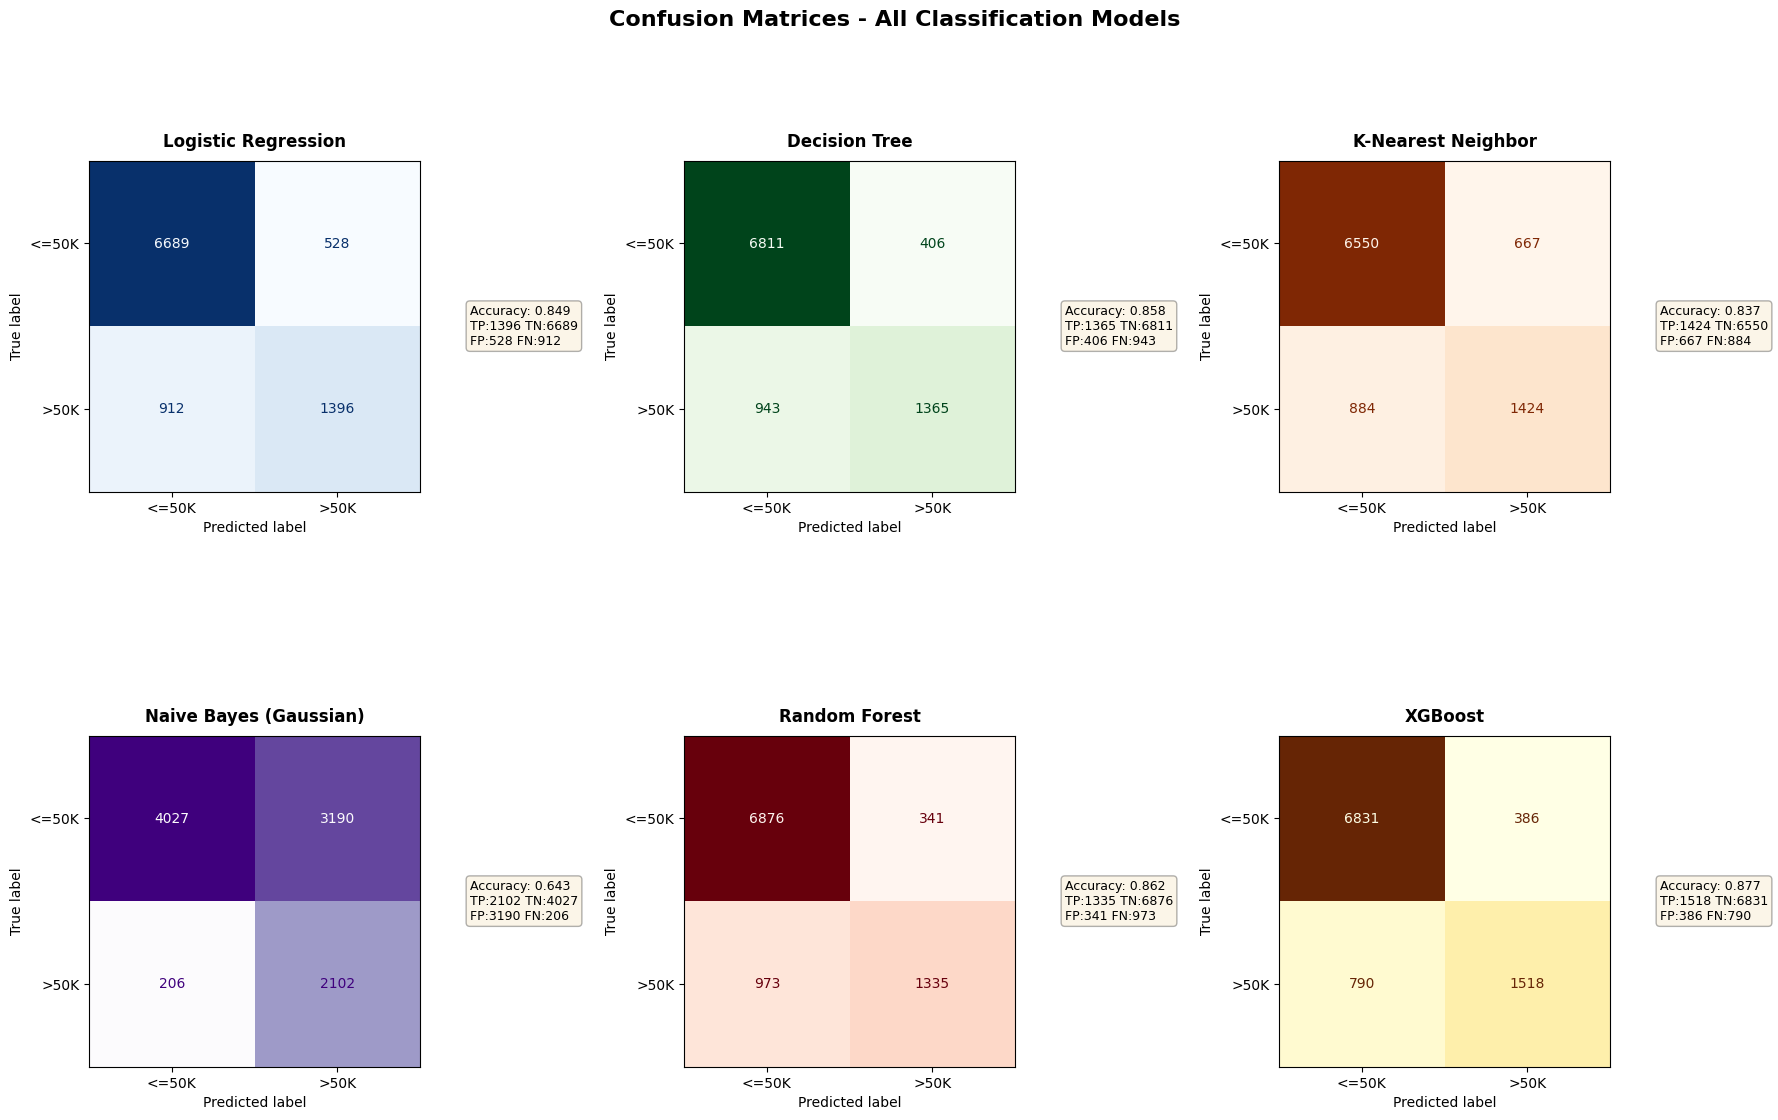

In [15]:
# Generate confusion matrices for all models using stored predictions
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Confusion Matrices - All Classification Models', fontsize=16, fontweight='bold', y=0.995)

model_names = list(trained_models.keys())
colors = ['Blues', 'Greens', 'Oranges', 'Purples', 'Reds', 'YlOrBr']

for idx, model_name in enumerate(model_names):
    ax = axes[idx // 3, idx % 3]

    # Get confusion matrix from results (already computed, no prediction needed!)
    cm = results[idx]['Confusion Matrix']

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                   display_labels=['<=50K', '>50K'])
    disp.plot(ax=ax, cmap=colors[idx], colorbar=False)
    ax.set_title(f'{model_name}', fontsize=12, fontweight='bold', pad=10)
    ax.grid(False)

    # Add metrics annotations
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    text = f'Accuracy: {accuracy:.3f}\nTP:{tp} TN:{tn}\nFP:{fp} FN:{fn}'
    ax.text(1.15, 0.5, text, transform=ax.transAxes, fontsize=9,
            verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.savefig('confusion_matrices_all.png', dpi=300, bbox_inches='tight')
plt.show()

### 6.8 Combined Confusion Matrix Analysis

CONFUSION MATRIX SUMMARY - ALL MODELS
                 Model  True Negative (TN)  False Positive (FP)  False Negative (FN)  True Positive (TP)  Specificity  Sensitivity (Recall)
   Logistic Regression                6689                  528                  912                1396     0.926839              0.604853
         Decision Tree                6811                  406                  943                1365     0.943744              0.591421
    K-Nearest Neighbor                6550                  667                  884                1424     0.907579              0.616984
Naive Bayes (Gaussian)                4027                 3190                  206                2102     0.557988              0.910745
         Random Forest                6876                  341                  973                1335     0.952750              0.578423
               XGBoost                6831                  386                  790                1518     0.946515     

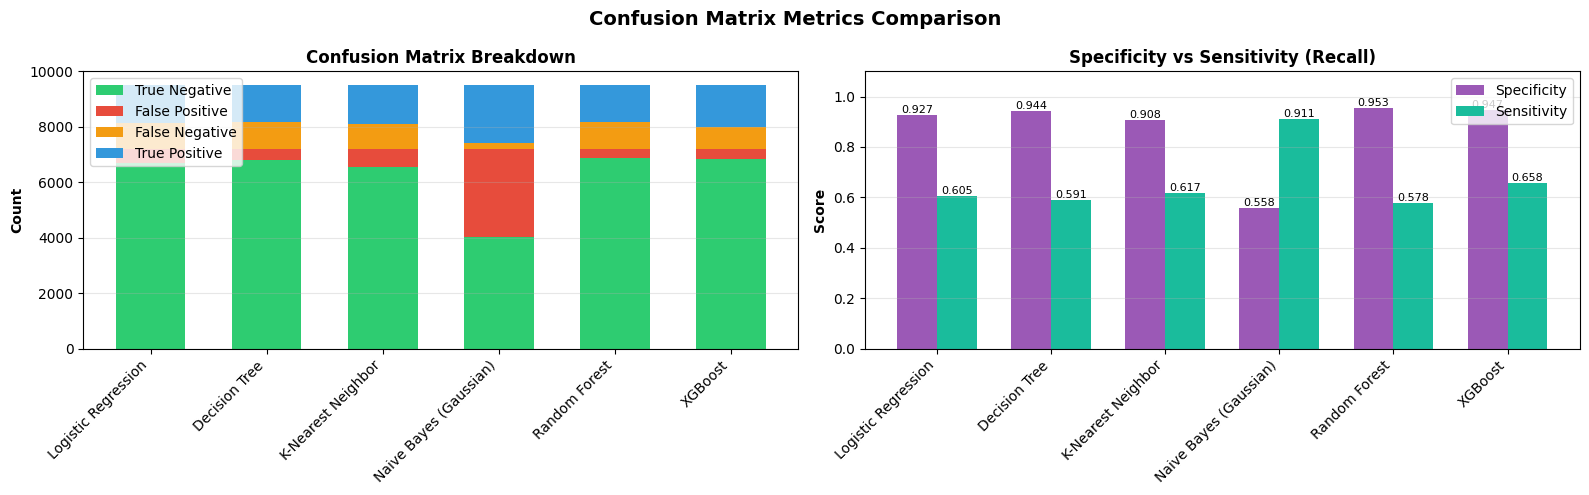


 Key Insights:
   • Best Sensitivity (Recall): Naive Bayes (Gaussian) (0.9107)
   • Best Specificity: Random Forest (0.9528)
   • Fewest False Negatives: Naive Bayes (Gaussian) (FN=206)
   • False negatives mean missing high-income individuals (>50K) - impacts targeting accuracy!


In [16]:
# Create a summary DataFrame of confusion matrix metrics using stored data
cm_summary = []

for result in results:
    model_name = result['Model']
    tn, fp, fn, tp = result['TN'], result['FP'], result['FN'], result['TP']

    cm_summary.append({
        'Model': model_name,
        'True Negative (TN)': tn,
        'False Positive (FP)': fp,
        'False Negative (FN)': fn,
        'True Positive (TP)': tp,
        'Specificity': tn / (tn + fp),
        'Sensitivity (Recall)': tp / (tp + fn)
    })

cm_df = pd.DataFrame(cm_summary)

print("="*100)
print("CONFUSION MATRIX SUMMARY - ALL MODELS")
print("="*100)
print(cm_df.to_string(index=False))
print("="*100)

# Visualize TP, TN, FP, FN comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Confusion Matrix Metrics Comparison', fontsize=14, fontweight='bold')

# Stacked bar chart for confusion matrix values
ax1 = axes[0]
x = np.arange(len(cm_df))
width = 0.6

p1 = ax1.bar(x, cm_df['True Negative (TN)'], width, label='True Negative', color='#2ecc71')
p2 = ax1.bar(x, cm_df['False Positive (FP)'], width, bottom=cm_df['True Negative (TN)'],
             label='False Positive', color='#e74c3c')
p3 = ax1.bar(x, cm_df['False Negative (FN)'], width,
             bottom=cm_df['True Negative (TN)'] + cm_df['False Positive (FP)'],
             label='False Negative', color='#f39c12')
p4 = ax1.bar(x, cm_df['True Positive (TP)'], width,
             bottom=cm_df['True Negative (TN)'] + cm_df['False Positive (FP)'] + cm_df['False Negative (FN)'],
             label='True Positive', color='#3498db')

ax1.set_ylabel('Count', fontweight='bold')
ax1.set_title('Confusion Matrix Breakdown', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(cm_df['Model'], rotation=45, ha='right')
ax1.legend(loc='upper left')
ax1.grid(axis='y', alpha=0.3)

# Specificity vs Sensitivity comparison
ax2 = axes[1]
x2 = np.arange(len(cm_df))
width2 = 0.35

bars1 = ax2.bar(x2 - width2/2, cm_df['Specificity'], width2, label='Specificity', color='#9b59b6')
bars2 = ax2.bar(x2 + width2/2, cm_df['Sensitivity (Recall)'], width2, label='Sensitivity', color='#1abc9c')

ax2.set_ylabel('Score', fontweight='bold')
ax2.set_title('Specificity vs Sensitivity (Recall)', fontweight='bold')
ax2.set_xticks(x2)
ax2.set_xticklabels(cm_df['Model'], rotation=45, ha='right')
ax2.legend()
ax2.set_ylim([0, 1.1])
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('confusion_matrix_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Identify best and worst performers
best_sensitivity = cm_df.loc[cm_df['Sensitivity (Recall)'].idxmax()]
best_specificity = cm_df.loc[cm_df['Specificity'].idxmax()]
worst_fn = cm_df.loc[cm_df['False Negative (FN)'].idxmin()]

print(f"\n Key Insights:")
print(f"   • Best Sensitivity (Recall): {best_sensitivity['Model']} ({best_sensitivity['Sensitivity (Recall)']:.4f})")
print(f"   • Best Specificity: {best_specificity['Model']} ({best_specificity['Specificity']:.4f})")
print(f"   • Fewest False Negatives: {worst_fn['Model']} (FN={worst_fn['False Negative (FN)']:.0f})")
print(f"   • False negatives mean missing high-income individuals (>50K) - impacts targeting accuracy!")

## 7. Model Comparison and Analysis

In [17]:
# Create comparison dataframe
results_df = pd.DataFrame(results)

# Display comparison table
print("\n" + "="*150)
print("MODEL COMPARISON TABLE")
print("="*150)
print(results_df.to_string(index=False))
print("="*150)


MODEL COMPARISON TABLE
                 Model  Accuracy  AUC Score  Precision   Recall  F1 Score  MCC Score  Training Time            Confusion Matrix   TN   FP  FN   TP
   Logistic Regression  0.848819   0.903222   0.725572 0.604853  0.659735   0.567438      37.413843  [[6689, 528], [912, 1396]] 6689  528 912 1396
         Decision Tree  0.858373   0.903182   0.770751 0.591421  0.669282   0.589402      83.531840  [[6811, 406], [943, 1365]] 6811  406 943 1365
    K-Nearest Neighbor  0.837165   0.882512   0.681014 0.616984  0.647420   0.543008     493.617061  [[6550, 667], [884, 1424]] 6550  667 884 1424
Naive Bayes (Gaussian)  0.643465   0.849248   0.397203 0.910745  0.553158   0.404192       1.248127 [[4027, 3190], [206, 2102]] 4027 3190 206 2102
         Random Forest  0.862047   0.914135   0.796539 0.578423  0.670181   0.597707      50.681584  [[6876, 341], [973, 1335]] 6876  341 973 1335
               XGBoost  0.876535   0.930764   0.797269 0.657712  0.720798   0.647377     911.5

### 7.1 Generate Markdown Comparison Table

In [19]:
# Generate markdown formatted table
def generate_markdown_table(df):
    """Generate a markdown formatted table"""
    md_table = "| Model | Accuracy | AUC Score | Precision | Recall | F1 Score | MCC Score|\n"
    md_table += "|-------|----------|-----------|-----------|--------|----------|-----------|\n"

    for _, row in df.iterrows():
        md_table += f"| {row['Model']} | {row['Accuracy']:.4f} | {row['AUC Score']:.4f} | "
        md_table += f"{row['Precision']:.4f} | {row['Recall']:.4f} | {row['F1 Score']:.4f} | "
        md_table += f"{row['MCC Score']:.4f} |\n"

    return md_table

markdown_table = generate_markdown_table(results_df)
print("\nMARKDOWN TABLE:")
print(markdown_table)

# Save to file
with open('model_comparison_table.md', 'w') as f:
    f.write("# Adult Income Classification - Model Comparison\n\n")
    f.write(markdown_table)


MARKDOWN TABLE:
| Model | Accuracy | AUC Score | Precision | Recall | F1 Score | MCC Score|
|-------|----------|-----------|-----------|--------|----------|-----------|
| Logistic Regression | 0.8488 | 0.9032 | 0.7256 | 0.6049 | 0.6597 | 0.5674 |
| Decision Tree | 0.8584 | 0.9032 | 0.7708 | 0.5914 | 0.6693 | 0.5894 |
| K-Nearest Neighbor | 0.8372 | 0.8825 | 0.6810 | 0.6170 | 0.6474 | 0.5430 |
| Naive Bayes (Gaussian) | 0.6435 | 0.8492 | 0.3972 | 0.9107 | 0.5532 | 0.4042 |
| Random Forest | 0.8620 | 0.9141 | 0.7965 | 0.5784 | 0.6702 | 0.5977 |
| XGBoost | 0.8765 | 0.9308 | 0.7973 | 0.6577 | 0.7208 | 0.6474 |



### 7.2 Visualize Model Performance

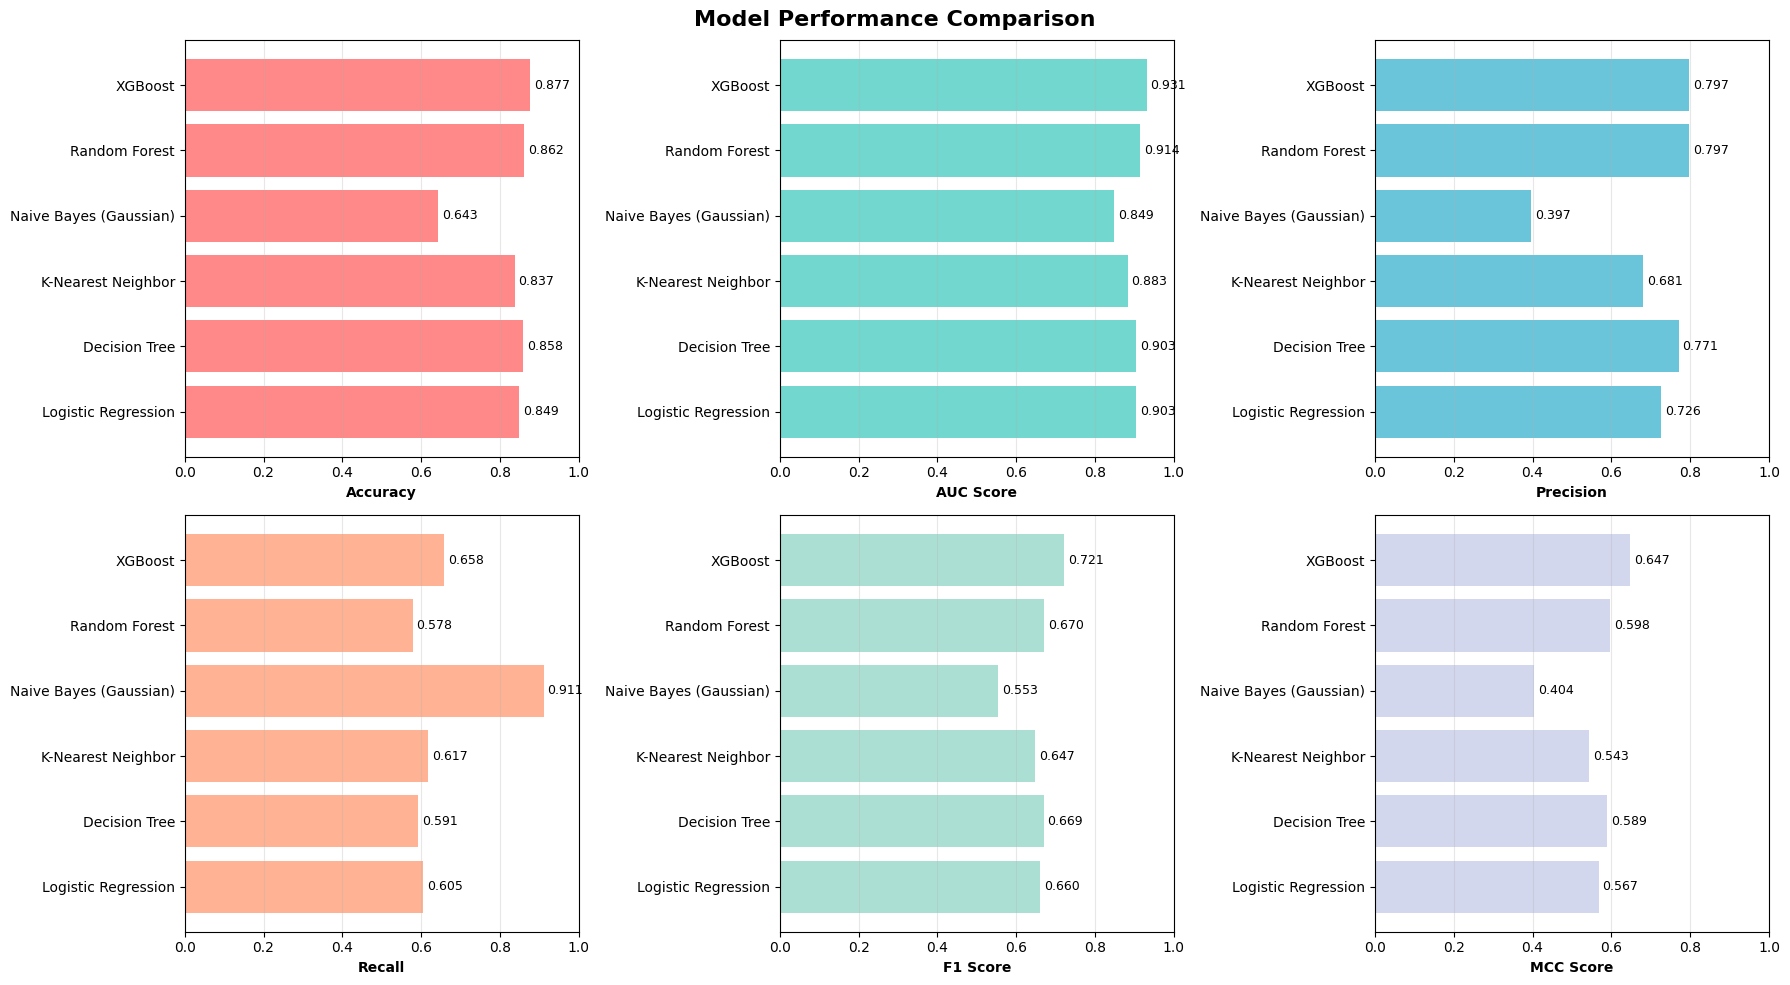

In [20]:
# Visualize model performance across all metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

metrics = ['Accuracy', 'AUC Score', 'Precision', 'Recall', 'F1 Score', 'MCC Score']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#C7CEEA']

for idx, (ax, metric, color) in enumerate(zip(axes.flat, metrics, colors)):
    values = results_df[metric].values
    models = results_df['Model'].values

    bars = ax.barh(models, values, color=color, alpha=0.8)
    ax.set_xlabel(metric, fontweight='bold')
    ax.set_xlim(0, 1)
    ax.grid(axis='x', alpha=0.3)

    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, values)):
        ax.text(val + 0.01, i, f'{val:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Export Models to Pickle Files

In [21]:
print("="*70)
print("EXPORTING MODELS TO PICKLE FILES")
print("="*70)

# Save all trained models
for model_name, model in trained_models.items():
    filename = f"model/{model_name.replace(' ', '_').replace('(', '').replace(')', '').lower()}.pkl"
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"{filename}")

# Save preprocessing objects
with open('model/preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)
print(f"model/preprocessor.pkl")

with open('model/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print(f"model/label_encoder.pkl")

EXPORTING MODELS TO PICKLE FILES
model/logistic_regression.pkl
model/decision_tree.pkl
model/k-nearest_neighbor.pkl
model/naive_bayes_gaussian.pkl
model/random_forest.pkl
model/xgboost.pkl
model/preprocessor.pkl
model/label_encoder.pkl
